# 1.2 End to end from ITMAL book

In [5]:
%config IPCompleter.greedy=True #intellisense

import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.requst.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    hoursing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    

## showing the data loaded


In [6]:
#general data show
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [7]:
housing  = load_housing_data()

a = housing["ocean_proximity"].value_counts()
b = housing.info()
c = housing.describe()

print(a)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64


## plotting the data

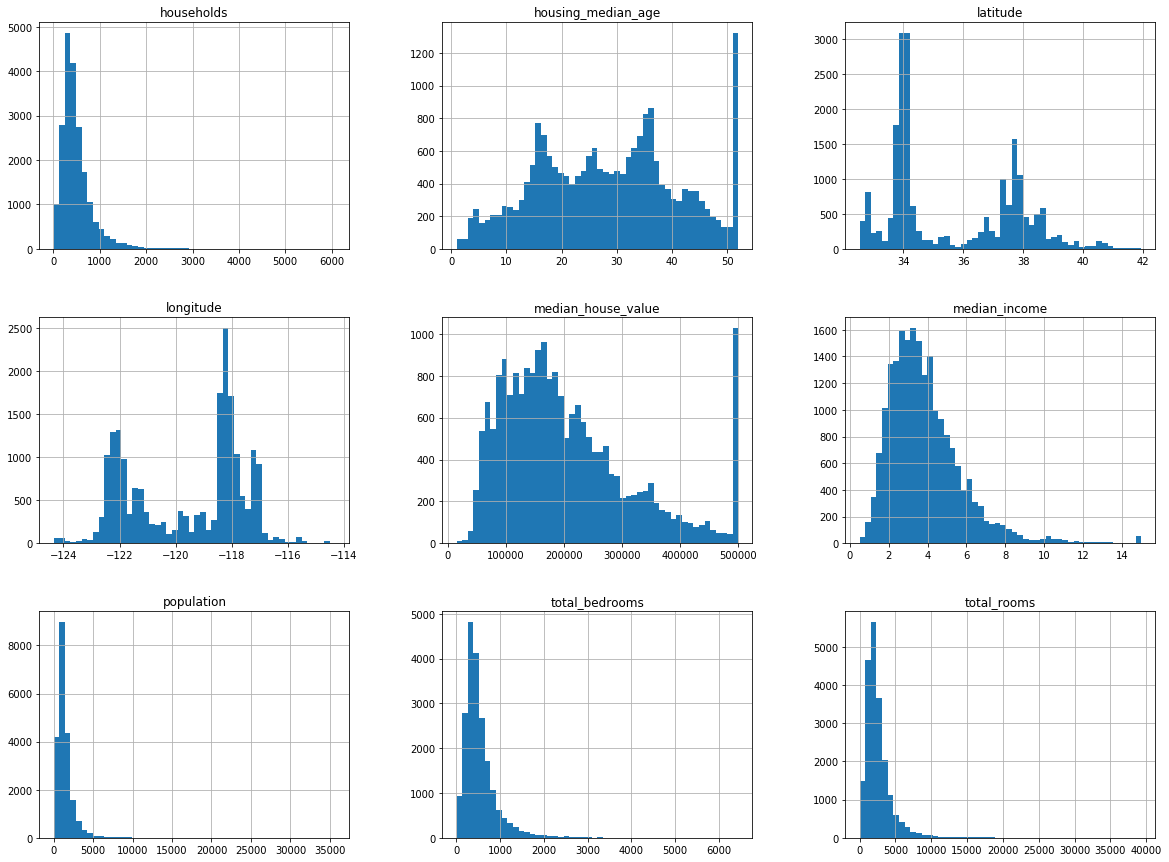

In [8]:
#histogram
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins = 50, figsize=(20,15))
plt.show()

## defining the test set
This first method is not good, it randomizes every run, the code will eventually have run on all the data, wich is not good for a test set, becuase then we have nothing new to evaluate on later.

In [9]:
#define test set

import numpy as np
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

#see sets
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


Lets try another way then.
here we will use hasing on a unique identifyer from the data, then we will split it 20% of 256 total possible outcomes

In [10]:
import hashlib
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio
def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]


# since longitude and lattitude is very unlikely to change, lets use those as identifiers

housing_with_id = housing.reset_index() # adds an `index` column

housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

print(len(train_set), "train +", len(test_set), "test")

16267 train + 4373 test


lastly, scikit learn also provides features for this


In [11]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


### stratified data
the above methods only randomises the data into groupds, however, suppose a factor is very relevant for the data, we have to make sure we got equal amount of the parameter, here we cang stratifi our data

In [12]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5) # divide to limit income catagories
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True) # merge greater than 5 into 5

next we will use the scikit learn stratifiedshufflekit based on the income catagory

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
strat_train_set["income_cat"].value_counts() / len(housing)

3.0    0.280475
2.0    0.255087
4.0    0.141037
5.0    0.091521
1.0    0.031880
Name: income_cat, dtype: float64

Now for removing the atribute, so our data is back to original
    
    

In [14]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

## visualising the data
after splitting up and analysing the data a bit, now we have to get deeper insight to the data

first lets make a copy of the data, so we dont mess it up

In [15]:
housing = strat_train_set.copy()

Visualise the location data first

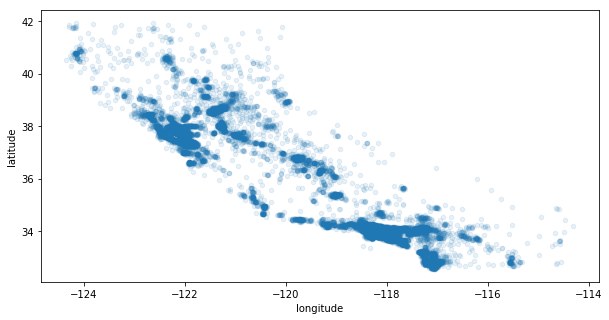

In [19]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, figsize=(10,5)
)

Next we look at the housing price on the same map, with the population AND the price in one go

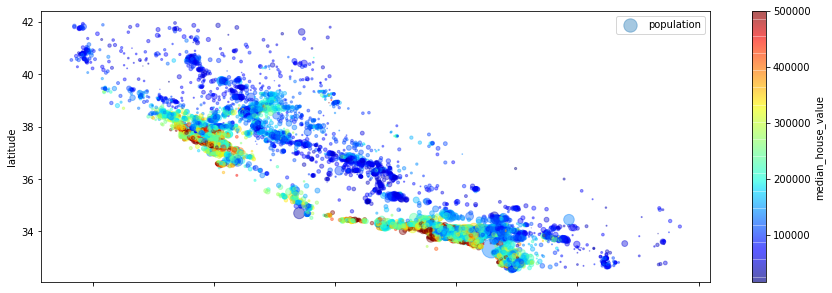

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population",
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, figsize=(15,5)
)
plt.legend()